In [1]:
import sys
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import networkit as nk
from tqdm import tqdm
import networkx as nx

from benji_girgs import generation, utils, plotting
import geopandas as gpd


from geopy import distance

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
fn = './flightlist_20190601_20190630_processed.pkl'
df = pd.read_pickle(fn)

In [3]:
# airports = list(np.union1d(df.origin.unique(), df.destination.unique()))
airports = list(np.load('airports_list.npy'))
len(airports)

10317

In [4]:
adf = pd.read_csv('./airport-codes_csv.csv')

adf_mini = adf.set_index('ident')
adf_mini = adf_mini.loc[airports]

# reversed s.t. latitude then longitude
adf_mini['coordinates'] = adf_mini.coordinates.apply(lambda x: tuple(reversed([float(y) for y in x.split(', ')])))

adf_mini['lat'] = adf_mini['coordinates'].apply(lambda x: x[0])
adf_mini['long'] = adf_mini['coordinates'].apply(lambda x: x[1])


In [5]:
dists = pd.read_csv('airport_distances3.csv.gz')

dists = dists.iloc[:, 1:]
dists = dists.set_index('ident')

dists_np = dists.to_numpy()

a, b = adf_mini.loc['00AK'].coordinates, adf_mini.loc['00AZ'].coordinates
a, b
distance.distance(a, b)

((59.94919968, -151.695999146), (34.305599212646484, -112.16500091552734))

Distance(4031.3139530844023)

In [6]:

g = nk.Graph(len(airports), weighted=True)
print(g.isWeighted())
pair_counts = df.groupby(['airport_pair']).aircraft_uid.count()
thresh = 1
for pair, count in tqdm(pair_counts.items()):
    u, v = tuple(pair)
    u_id, v_id = airports.index(u), airports.index(v)
    _ = g.addEdge(u_id, v_id, w=count)
    

    
weight_thresh = 1
gthresh = nk.Graph(len(airports))
for u, v, weight in tqdm(g.iterEdgesWeights()):
    if weight >= weight_thresh:
        _ = gthresh.addEdge(u, v)

True


130704it [00:11, 11790.87it/s]
130704it [00:00, 3233165.51it/s]


In [7]:
sub_indices = np.random.choice(dists_np.shape[0], 2000)
dists_np2 = dists_np[sub_indices][:, sub_indices]
gthresh2 = utils.quick_subgraph(gthresh, sub_indices)

In [11]:
D_hi

array([0.5       ,        inf, 0.70710678, ..., 0.25      , 1.        ,
       0.70710678])

/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_19388/482520811.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.linalg.adjacency_matrix(gnx).todense()
/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_19388/482520811.py:7: RuntimeWarning: divide by zero encountered in power
  D_hi = D**(-0.5)
/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_19388/482520811.py:9: RuntimeWarning: divide by zero encountered in divide
  M = np.diag(1/D) @ A
/var/folders/60/0t2c_bns6n3c7kjhdk4d4wk80000gn/T/ipykernel_19388/482520811.py:9: RuntimeWarning: invalid value encountered in matmul
  M = np.diag(1/D) @ A


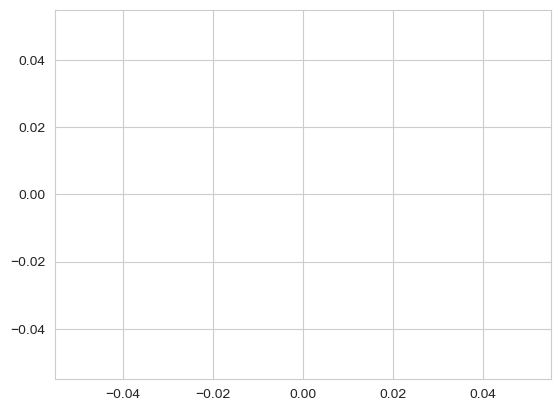

In [8]:
gnx = nk.nxadapter.nk2nx(gthresh2)

A = nx.linalg.adjacency_matrix(gnx).todense()

D = np.array([x[1] for x in (gnx.degree)])
D_h = D**(0.5)
D_hi = D**(-0.5)

M = np.diag(1/D) @ A
M = 0.5 * M + 0.5 * np.eye(M.shape[0])
# S = np.diag(D_hi) @ A @ np.diag(D_hi)
S = np.diag(D_h) @ M @ np.diag(D_hi)

w, V = np.linalg.eigh(S)

# S = V @ np.diag(w) @ V.T
# M = D^{-1/2} @ S @ D^{1/2} 
# = D^{-1/2} @ V @ np.diag(w) @ V.T @ D^{1/2}
# = Phi @ np.diag(w) @ Psi.T
# Phi = D^{-1/2} @ V
# Psi = D^{1/2} @ V


Phi = np.diag(D_hi) @ V
Psi = np.diag(D_h) @ V

n = Phi.shape[0]

def diff_map(i, t):
    # n = 5, so 0, 1, 2, 3, 4, we want to get 3, 2, 1, 0
    # so 5-2 -> -1, -1
    return np.array([Phi[i, j] for j in range(n-2, -1, -1)]) * (np.flip(w)[1:]**t)

plt.plot((np.flip(w)**5)[:10], marker='x')

# sorted(w)

In [9]:
w

array([nan, nan, nan, ..., nan, nan, nan])